## COMP90049 - Assignment2 code

### Data Prepararing

In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import pickle

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import vstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report

In [81]:
# Load labelled datasets (train and evaluate)
df_train_label = pd.read_csv('TMDB_train.csv')
df_evaluate_label = pd.read_csv('TMDB_evaluate.csv')

# check data shape
print(df_train_label.shape)
print(df_evaluate_label.shape)

(100000, 44)
(20000, 44)


In [82]:
# Load the unlabelled datasets
df_train_unlabel = pd.read_csv('TMDB_unlabelled.csv')

# check data shape
print(df_train_unlabel.shape)

C:\Users\Yuting\AppData\Local\Temp\ipykernel_12012\4290022973.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_unlabel = pd.read_csv('TMDB_unlabelled.csv')


(254701, 42)


In [83]:
# Load the test datasets
df_test_data = pd.read_csv('TMDB_test.csv')

# check data shape
print(df_test_data.shape)

(20000, 42)


In [84]:
# Encode the 'original_language' feature in all datasets using LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the concatenated original_language lists from all datasets
encoder.fit(df_train_label['original_language'].to_list() + df_evaluate_label['original_language'].to_list() + df_test_data['original_language'].to_list() + df_train_unlabel['original_language'].to_list())

# Transform original_language feature to encoded values in all datasets
df_train_label['original_language'] = encoder.transform(df_train_label['original_language'])
df_evaluate_label['original_language'] = encoder.transform(df_evaluate_label['original_language'])
df_test_data['original_language'] = encoder.transform(df_test_data['original_language'])
df_train_unlabel['original_language'] = encoder.transform(df_train_unlabel['original_language'])

# check data shape after encoding
print(df_train_label.shape)
print(df_evaluate_label.shape)
print(df_test_data.shape)
print(df_train_unlabel.shape)

(100000, 44)
(20000, 44)
(20000, 42)
(254701, 42)


In [85]:
# to extract the year from a date string or integer
def extract_year(date_str):
    date_str = str(date_str)  # Ensure input is converted to string
    if '/' in date_str:   # Check if date format contains '/'
        parts = date_str.split('/')
        return int(parts[-1])  # Extract and return the last part as year
    elif '-' in date_str:  # Check if date format contains '-'
        parts = date_str.split('-')
        return int(parts[0])  # Extract and return the first part as year
    elif len(date_str) == 4 and date_str.isdigit():  # Check if date string is 4 digits and all digits
        return int(date_str)  # Return the date string as integer
    else:     # If none of the above conditions match, return the original date string
        return date_str
    
df_train_unlabel['release_year'] = df_train_unlabel['release_year'].apply(extract_year)

In [9]:
# remove text feature and label
X_train_label_non_text = df_train_label.drop(columns=['id','title', 'overview', 'tagline', 'production_companies', 'rate_category', 'average_rate'], axis=1)

y_train_label = df_train_label['rate_category']
y_train_label2 = df_train_label['average_rate']

In [10]:
X_evaluate_label_non_text = df_evaluate_label.drop(columns=['id','title', 'overview', 'tagline', 'production_companies', 'rate_category', 'average_rate'], axis=1)

y_evaluate_label = df_evaluate_label['rate_category']
y_evaluate_label2 = df_evaluate_label['average_rate']

In [11]:
X_test_non_text = df_test_data.drop(columns=['id','title', 'overview', 'tagline', 'production_companies'], axis=1)

In [12]:
X_unlabel_non_text = df_train_unlabel.drop(columns=['id','title', 'overview', 'tagline', 'production_companies'], axis=1)
X_unlabel_non_text.shape

(254701, 37)

### Train Model by Using Non-Text Features

In [13]:
# initialize model
zero_r_classifier = DummyClassifier(strategy="most_frequent")
decision_tree_classifier = DecisionTreeClassifier(criterion='entropy')
lgr = LogisticRegression(max_iter=1000)
rf_classifier = RandomForestClassifier(criterion='entropy')

classifiers = {
    "Zero-R Classifier": zero_r_classifier,
    "Decision Tree": decision_tree_classifier,
    "Logistic Regression": lgr,
    "Random Forest": rf_classifier
}

In [42]:
# train model by using non-text feature from label dataset
# Evaluate classifiers using the selected features
print("-- Evaluate classifiers using the labeled non-text features --")
for name, classifier in classifiers.items():
    # Train classifier on selected features
    classifier.fit(X_train_label_non_text, y_train_label)
        
    # Predict
    y_pred = classifier.predict(X_evaluate_label_non_text)
        
    # Calculate accuracy
    accuracy = accuracy_score(y_evaluate_label, y_pred)
    print(f"{name} Accuracy: {accuracy:.3f}")
    # Print report with evaluation metrics
    print(classification_report(y_evaluate_label, y_pred))

-- Evaluate classifiers using the labeled non-text features --
Zero-R Classifier Accuracy: 0.271
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2184
           1       0.00      0.00      0.00      2829
           2       0.00      0.00      0.00      5119
           3       0.27      1.00      0.43      5420
           4       0.00      0.00      0.00      2791
           5       0.00      0.00      0.00      1657

    accuracy                           0.27     20000
   macro avg       0.05      0.17      0.07     20000
weighted avg       0.07      0.27      0.12     20000



C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree Accuracy: 0.656
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      2184
           1       0.63      0.63      0.63      2829
           2       0.66      0.67      0.66      5119
           3       0.69      0.68      0.69      5420
           4       0.65      0.64      0.64      2791
           5       0.63      0.62      0.62      1657

    accuracy                           0.66     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.66      0.66      0.66     20000

Logistic Regression Accuracy: 0.271
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2184
           1       0.00      0.00      0.00      2829
           2       0.22      0.00      0.00      5119
           3       0.27      1.00      0.43      5420
           4       0.58      0.00      0.01      2791
           5       0.00      0.00      0.00      1657

    accurac

C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Accuracy: 0.691
              precision    recall  f1-score   support

           0       0.66      0.69      0.68      2184
           1       0.69      0.63      0.66      2829
           2       0.66      0.71      0.68      5119
           3       0.71      0.75      0.73      5420
           4       0.76      0.62      0.68      2791
           5       0.68      0.67      0.68      1657

    accuracy                           0.69     20000
   macro avg       0.69      0.68      0.68     20000
weighted avg       0.69      0.69      0.69     20000



### Feature Selection

In [34]:
# Using f_classif to do feature selection
# select most related non-text features based on labeld datasets.
from sklearn.feature_selection import SelectKBest, f_classif

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Define the number of features to select
k_values = [37, 30, 25, 20, 10, 5]

for k in k_values:
    print(f"\nTop {k} Features:")
    
    # Initialize SelectKBest with ANOVA F-value as the scoring function
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_label_non_text_selected = selector.fit_transform(X_train_label_non_text, y_train_label)
    X_evaluate_label_non_text_selected = selector.transform(X_evaluate_label_non_text)
    
    # Get the indices of the selected features
    selected_feature_indices = selector.get_support()
    
    # Get the names of the selected features
    selected_feature_names = X_train_label_non_text.columns[selected_feature_indices]
    print("Selected Features:", selected_feature_names)
    
    # Evaluate classifiers using the selected features
    for name, classifier in classifiers.items():
        # Train classifier on selected features
        classifier.fit(X_train_label_non_text_selected, y_train_label)
        
        # Predict
        y_pred = classifier.predict(X_evaluate_label_non_text_selected)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_evaluate_label, y_pred)
        print(f"{name} Accuracy: {accuracy:.3f}")


Top 37 Features:
Selected Features: Index(['release_year', 'runtime', 'budget', 'revenue', 'adult',
       'original_language', 'popularity', 'genre_Action', 'genre_Adventure',
       'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
       'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History',
       'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance',
       'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller',
       'genre_War', 'genre_Western', 'product_of_Canada', 'product_of_France',
       'product_of_Germany', 'product_of_India', 'product_of_Italy',
       'product_of_Japan', 'product_of_Spain', 'product_of_UK',
       'product_of_USA', 'product_of_other_countries', 'vote_count'],
      dtype='object')
Zero-R Classifier Accuracy: 0.271
Decision Tree Accuracy: 0.655
Logistic Regression Accuracy: 0.271
Random Forest Accuracy: 0.691

Top 30 Features:
Selected Features: Index(['release_year', 'runtime', 'budget', 'revenue', 'adult

### Using self-training for models using non-text features

In [18]:
# Test whether the self-training model improve the performance of decision tree
X_train_both = np.vstack([X_train_label_non_text, X_unlabel_non_text])

# Create labels for unlabeled data (use -1 to represent unlabeled data)
y_both = y_train_label.to_list() + [-1] * (X_unlabel_non_text.shape[0])

# Train a semi-supervised learning model
self_training_model = SelfTrainingClassifier(decision_tree_classifier, criterion = 'k_best', k_best=1000)
self_training_model.fit(X_train_both, y_both)

y_pred_eval = self_training_model.predict(X_evaluate_label_non_text)

# Evaluate the performance
print(classification_report(y_evaluate_label, y_pred_eval))

(354701, 37)
              precision    recall  f1-score   support

           0       0.63      0.64      0.64      2184
           1       0.62      0.62      0.62      2829
           2       0.66      0.66      0.66      5119
           3       0.69      0.68      0.69      5420
           4       0.65      0.64      0.64      2791
           5       0.63      0.64      0.63      1657

    accuracy                           0.66     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.66      0.66      0.66     20000



In [19]:
# test prediction save in csv
y_pred = self_training_model.predict(X_test_non_text)

df_test_data['rate_category'] = y_pred

predictions = df_test_data[['id', 'rate_category']]
predictions.to_csv('dt_all_non_text_predictions(label + unlabel).csv', index=False)

In [20]:
# Test whether the self-training model improve the performance of logistic regression
X_train_both = np.vstack([X_train_label_non_text, X_unlabel_non_text])

# Create labels for unlabeled data (use -1 to represent unlabeled data)
y_both = y_train_label.to_list() + [-1] * (X_unlabel_non_text.shape[0])


# Train a semi-supervised learning model

self_training_model = SelfTrainingClassifier(lgr, criterion = 'k_best', k_best=1000)
self_training_model.fit(X_train_both, y_both)

y_pred_eval = self_training_model.predict(X_evaluate_label_non_text)


# Evaluate the performance
print(classification_report(y_evaluate_label, y_pred_eval))

(354701, 37)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2184
           1       0.00      0.00      0.00      2829
           2       0.25      0.00      0.00      5119
           3       0.27      1.00      0.43      5420
           4       0.64      0.01      0.01      2791
           5       0.00      0.00      0.00      1657

    accuracy                           0.27     20000
   macro avg       0.19      0.17      0.07     20000
weighted avg       0.23      0.27      0.12     20000



In [22]:
# Test whether the self-training model improve the performance of random forest
X_train_both = np.vstack([X_train_label_non_text, X_unlabel_non_text])

# Create labels for unlabeled data (use -1 to represent unlabeled data)
y_both = y_train_label.to_list() + [-1] * (X_unlabel_non_text.shape[0])


# Train a semi-supervised learning model

self_training_model = SelfTrainingClassifier(rf_classifier, criterion = 'k_best', k_best=1000)
self_training_model.fit(X_train_both, y_both)

y_pred_eval = self_training_model.predict(X_evaluate_label_non_text)


# Evaluate the performance
print(classification_report(y_evaluate_label, y_pred_eval))

(354701, 37)
              precision    recall  f1-score   support

           0       0.66      0.69      0.68      2184
           1       0.70      0.63      0.66      2829
           2       0.65      0.71      0.68      5119
           3       0.70      0.75      0.73      5420
           4       0.76      0.62      0.68      2791
           5       0.69      0.67      0.68      1657

    accuracy                           0.69     20000
   macro avg       0.70      0.68      0.68     20000
weighted avg       0.69      0.69      0.69     20000



In [23]:
# test prediction save in csv
y_pred = self_training_model.predict(X_test_non_text)

df_test_data['rate_category'] = y_pred

predictions = df_test_data[['id', 'rate_category']]
predictions.to_csv('rf_all_non_text_predictions(label + unlabel).csv', index=False)

### Hypothesis: Data imbalance affects the performance of model prediction. Does balancing the data improve the model performance?
### Experiment: Use the class_balanced method to balance the data and compare the accuracy before and after balancing (Use the original 37 features for the experiment)

In [31]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_label), y=y_train_label)

# train random forest using balanced data
balanced_rf_model = RandomForestClassifier(criterion='entropy', class_weight=dict(zip(np.unique(y_train_label), class_weights)))

#-----

X_train_both = np.vstack([X_train_label_non_text, X_unlabel_non_text])
print(X_train_both.shape)

# Create labels for unlabeled data (use -1 to represent unlabeled data)
y_both = y_train_label.to_list() + [-1] * (X_unlabel_non_text.shape[0])


# Train a semi-supervised learning model

self_training_model = SelfTrainingClassifier(balanced_rf_model, criterion = 'k_best', k_best=1000)
self_training_model.fit(X_train_both, y_both)

y_pred_eval = self_training_model.predict(X_evaluate_label_non_text)


# Evaluate the performance
print(classification_report(y_evaluate_label, y_pred_eval))

(354701, 37)
              precision    recall  f1-score   support

           0       0.66      0.69      0.67      2184
           1       0.70      0.62      0.66      2829
           2       0.66      0.71      0.68      5119
           3       0.71      0.75      0.73      5420
           4       0.76      0.62      0.68      2791
           5       0.68      0.68      0.68      1657

    accuracy                           0.69     20000
   macro avg       0.69      0.68      0.68     20000
weighted avg       0.69      0.69      0.69     20000



In [33]:
# test prediction save in csv
y_pred = self_training_model.predict(X_test_non_text)

df_test_data['rate_category'] = y_pred

predictions = df_test_data[['id', 'rate_category']]
predictions.to_csv('rf_all_non_text_balanced(label + unlabel).csv', index=False)

In [114]:
# use semi-supervised learning to improve performance
# Combine labeled and unlabeled data (non-text)

# random forest
X_train_both = np.vstack([X_train_non_text, X_unlabel_non_text])
print(X_train_both.shape)

# Create labels for unlabeled data (use -1 to represent unlabeled data)
y_both = y_train_label.to_list() + [-1] * (X_unlabel_non_text.shape[0])


# Train a semi-supervised learning model

self_training_model = SelfTrainingClassifier(rf_classifier, criterion = 'k_best', k_best=1000)
self_training_model.fit(X_train_both, y_both)

y_pred = self_training_model.predict(X_test_non_text)

df_test_data['rate_category'] = y_pred

# Evaluate the performance
print(classification_report(y_evaluate_label, y_pred))

predictions = df_test_data[['id', 'rate_category']]
predictions.to_csv('rf_non_text_predictions(label + unlabel).csv', index=False)

(354701, 30)


### Train Model by Using Text Features

In [14]:
# load text feature
# bow
train_concat_bow = scipy.sparse.load_npz('TMDB_text_features_bow/train_concat_bow.npz')
eval_concat_bow = scipy.sparse.load_npz('TMDB_text_features_bow/eval_concat_bow.npz')
test_concat_bow = scipy.sparse.load_npz('TMDB_text_features_bow/test_concat_bow.npz')
unlabelled_concat_bow = scipy.sparse.load_npz('TMDB_text_features_bow/unlabelled_concat_bow.npz')

print(train_concat_bow.shape)
print(eval_concat_bow.shape)
print(test_concat_bow.shape)
print(unlabelled_concat_bow.shape)

(100000, 1000)
(20000, 1000)
(20000, 1000)
(254701, 1000)


In [48]:
# test the accuracy of models when using text features (bow)
print("-- Evaluate classifiers using the labeled text features(bow) --")
for name, classifier in classifiers.items():
    # Train classifier on selected features
    classifier.fit(train_concat_bow.toarray(), y_train_label)
        
    # Predict
    y_pred = classifier.predict(eval_concat_bow.toarray())
        
    # Calculate accuracy
    accuracy = accuracy_score(y_evaluate_label, y_pred)
    print(f"{name} Accuracy: {accuracy:.3f}")
    print(classification_report(y_evaluate_label, y_pred))

-- Evaluate classifiers using the labeled text features(bow) --
Zero-R Classifier Accuracy: 0.271
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2184
           1       0.00      0.00      0.00      2829
           2       0.00      0.00      0.00      5119
           3       0.27      1.00      0.43      5420
           4       0.00      0.00      0.00      2791
           5       0.00      0.00      0.00      1657

    accuracy                           0.27     20000
   macro avg       0.05      0.17      0.07     20000
weighted avg       0.07      0.27      0.12     20000



C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree Accuracy: 0.617
              precision    recall  f1-score   support

           0       0.60      0.57      0.58      2184
           1       0.59      0.59      0.59      2829
           2       0.63      0.65      0.64      5119
           3       0.65      0.66      0.65      5420
           4       0.59      0.58      0.59      2791
           5       0.59      0.57      0.58      1657

    accuracy                           0.62     20000
   macro avg       0.61      0.60      0.60     20000
weighted avg       0.62      0.62      0.62     20000

Logistic Regression Accuracy: 0.307
              precision    recall  f1-score   support

           0       0.28      0.06      0.10      2184
           1       0.27      0.06      0.10      2829
           2       0.30      0.48      0.37      5119
           3       0.32      0.54      0.40      5420
           4       0.28      0.08      0.13      2791
           5       0.32      0.15      0.20      1657

    accurac

In [15]:
# tfidf
train_concat_tfidf = scipy.sparse.load_npz('TMDB_text_features_tfidf/train_concat_tfidf.npz')
eval_concat_tfidf = scipy.sparse.load_npz('TMDB_text_features_tfidf/eval_concat_tfidf.npz')
test_concat_tfidf = scipy.sparse.load_npz('TMDB_text_features_tfidf/test_concat_tfidf.npz')
unlabelled_concat_tfidf = scipy.sparse.load_npz('TMDB_text_features_tfidf/unlabelled_concat_tfidf.npz')

print(train_concat_tfidf.shape)
print(eval_concat_tfidf.shape)
print(test_concat_tfidf.shape)
print(unlabelled_concat_tfidf.shape)

(100000, 1000)
(20000, 1000)
(20000, 1000)
(254701, 1000)


In [47]:
# test the accuracy of models when using text features (tfidf)
print("-- Evaluate classifiers using the labeled text features(tfidf) --")
for name, classifier in classifiers.items():
    # Train classifier on selected features
    classifier.fit(train_concat_tfidf.toarray(), y_train_label)
        
    # Predict
    y_pred = classifier.predict(eval_concat_tfidf.toarray())
        
    # Calculate accuracy
    accuracy = accuracy_score(y_evaluate_label, y_pred)
    print(f"{name} Accuracy: {accuracy:.3f}")
    print(classification_report(y_evaluate_label, y_pred))

-- Evaluate classifiers using the labeled text features(tfidf) --
Zero-R Classifier Accuracy: 0.271
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2184
           1       0.00      0.00      0.00      2829
           2       0.00      0.00      0.00      5119
           3       0.27      1.00      0.43      5420
           4       0.00      0.00      0.00      2791
           5       0.00      0.00      0.00      1657

    accuracy                           0.27     20000
   macro avg       0.05      0.17      0.07     20000
weighted avg       0.07      0.27      0.12     20000



C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree Accuracy: 0.612
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      2184
           1       0.59      0.58      0.59      2829
           2       0.63      0.63      0.63      5119
           3       0.64      0.66      0.65      5420
           4       0.60      0.59      0.59      2791
           5       0.58      0.57      0.57      1657

    accuracy                           0.61     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.61      0.61      0.61     20000

Logistic Regression Accuracy: 0.306
              precision    recall  f1-score   support

           0       0.30      0.07      0.11      2184
           1       0.27      0.07      0.11      2829
           2       0.30      0.45      0.36      5119
           3       0.32      0.54      0.40      5420
           4       0.26      0.08      0.13      2791
           5       0.31      0.17      0.22      1657

    accurac

### Using self-training for models using text features

In [49]:
# Combine unlabel text and label text（Random Forest）(bow)
all_text_data = vstack([train_concat_bow, unlabelled_concat_bow])

# Create labels for unlabeled data (we'll use -1 to represent unlabeled data)
y_text = y_train_label.to_list() + [-1] * (unlabelled_concat_bow.shape[0])    
        
self_training_model = SelfTrainingClassifier(rf_classifier, criterion = 'k_best', k_best=1000)
self_training_model.fit(all_text_data, y_text)

y_pred = self_training_model.predict(eval_concat_bow)

# Evaluate the performance
print(classification_report(y_evaluate_label, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.51      0.67      2184
           1       0.93      0.51      0.66      2829
           2       0.55      0.74      0.63      5119
           3       0.54      0.77      0.64      5420
           4       0.92      0.52      0.67      2791
           5       0.82      0.56      0.67      1657

    accuracy                           0.65     20000
   macro avg       0.79      0.60      0.66     20000
weighted avg       0.72      0.65      0.65     20000



In [50]:
# Predict
y_pred = self_training_model.predict(test_concat_bow)

df_test_data['rate_category'] = y_pred

# Save to a CSV file
predictions = df_test_data[['id', 'rate_category']]
predictions.to_csv('rf_text_predictions(label unlabel)(bow).csv', index=False)

In [51]:
# Combine unlabel text and label text（Decision Tree）(bow)

DS = DecisionTreeClassifier(criterion='entropy',splitter='random')

DS.fit(train_concat_bow, y_train_label)

all_text_data = vstack([train_concat_bow, unlabelled_concat_bow])

# Create labels for unlabeled data (we'll use -1 to represent unlabeled data)
y_text = y_train_label.to_list() + [-1] * (unlabelled_concat_bow.shape[0])

self_training_model = SelfTrainingClassifier(DS, criterion = 'k_best', k_best=1000)
self_training_model.fit(all_text_data, y_text)

y_pred = self_training_model.predict(eval_concat_bow)

# Evaluate the performance
print(classification_report(y_evaluate_label, y_pred))

#----
y_pred_DT_text = self_training_model.predict(test_concat_bow)

df_test_data['rate_category'] = y_pred_DT_text

# Save to a CSV file

predictions = df_test_data[['id', 'rate_category']]
predictions.to_csv('dt_text_predictions(label unlabel)(bow).csv', index=False)

              precision    recall  f1-score   support

           0       0.58      0.57      0.57      2184
           1       0.59      0.58      0.58      2829
           2       0.63      0.64      0.64      5119
           3       0.64      0.65      0.65      5420
           4       0.60      0.58      0.59      2791
           5       0.58      0.58      0.58      1657

    accuracy                           0.61     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.61      0.61      0.61     20000



In [52]:
# Combine unlabel text and label text（Logistic Regression）(bow)
self_training_model = SelfTrainingClassifier(lgr, criterion = 'k_best', k_best=1000)
self_training_model.fit(all_text_data, y_text)

y_pred = self_training_model.predict(eval_concat_bow)

# Evaluate the performance
print(classification_report(y_evaluate_label, y_pred))

#----
y_pred_lgr_text = self_training_model.predict(test_concat_bow)

df_test_data['rate_category'] = y_pred_lgr_text

# Save to a CSV file

predictions = df_test_data[['id', 'rate_category']]
predictions.to_csv('lgr_text_predictions(label unlabel)(bow).csv', index=False)

              precision    recall  f1-score   support

           0       0.28      0.06      0.09      2184
           1       0.27      0.06      0.10      2829
           2       0.30      0.47      0.36      5119
           3       0.32      0.52      0.40      5420
           4       0.27      0.07      0.11      2791
           5       0.27      0.22      0.24      1657

    accuracy                           0.30     20000
   macro avg       0.29      0.23      0.22     20000
weighted avg       0.29      0.30      0.26     20000



In [17]:
# Combine unlabel text and label text（Random Forest）(tfidf)
all_text_data_2 = vstack([train_concat_tfidf, unlabelled_concat_tfidf])

# Create labels for unlabeled data (we'll use -1 to represent unlabeled data)
y_text_2 = y_train_label.to_list() + [-1] * (unlabelled_concat_tfidf.shape[0])

#decision_tree_classifier = DecisionTreeClassifier(criterion='entropy',splitter='random')      
        
self_training_model = SelfTrainingClassifier(rf_classifier, criterion = 'k_best', k_best=1000)
self_training_model.fit(all_text_data_2, y_text_2)

y_pred = self_training_model.predict(eval_concat_tfidf)

# Evaluate the performance
print(classification_report(y_evaluate_label, y_pred))

#----
y_pred_rf_2 = self_training_model.predict(test_concat_tfidf)

df_test_data['rate_category'] = y_pred_rf_2

# Save to a CSV file

predictions = df_test_data[['id', 'rate_category']]
predictions.to_csv('rf_text_predictions(label unlabel)(tfidf).csv', index=False)

              precision    recall  f1-score   support

           0       0.96      0.51      0.67      2184
           1       0.94      0.51      0.66      2829
           2       0.55      0.74      0.63      5119
           3       0.54      0.77      0.64      5420
           4       0.93      0.52      0.67      2791
           5       0.84      0.56      0.67      1657

    accuracy                           0.65     20000
   macro avg       0.79      0.60      0.66     20000
weighted avg       0.72      0.65      0.65     20000



In [23]:
# Combine unlabel text and label text（Decision Tree）(tfidf)

self_training_model = SelfTrainingClassifier(decision_tree_classifier, criterion = 'k_best', k_best=1000)
self_training_model.fit(all_text_data_2, y_text_2)

y_pred = self_training_model.predict(eval_concat_tfidf)

# Evaluate the performance
print(classification_report(y_evaluate_label, y_pred))

#----
y_pred_dt_2 = self_training_model.predict(test_concat_tfidf)

df_test_data['rate_category'] = y_pred_dt_2

# Save to a CSV file

predictions = df_test_data[['id', 'rate_category']]
predictions.to_csv('dt_text_predictions(label unlabel)(tfidf).csv', index=False)

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      2184
           1       0.58      0.58      0.58      2829
           2       0.63      0.64      0.64      5119
           3       0.65      0.65      0.65      5420
           4       0.58      0.57      0.58      2791
           5       0.59      0.58      0.59      1657

    accuracy                           0.61     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.61      0.61      0.61     20000



In [24]:
# Combine unlabel text and label text（Logistic Regression）(tfidf)
self_training_model = SelfTrainingClassifier(lgr, criterion = 'k_best', k_best=1000)
self_training_model.fit(all_text_data_2, y_text_2)

y_pred = self_training_model.predict(eval_concat_tfidf)

# Evaluate the performance
print(classification_report(y_evaluate_label, y_pred))

#----
y_pred_lgr_2 = self_training_model.predict(test_concat_tfidf)

df_test_data['rate_category'] = y_pred_lgr_2

# Save to a CSV file

predictions = df_test_data[['id', 'rate_category']]
predictions.to_csv('lgr_text_predictions(label unlabel)(tfidf).csv', index=False)

              precision    recall  f1-score   support

           0       0.28      0.07      0.11      2184
           1       0.27      0.07      0.11      2829
           2       0.30      0.45      0.36      5119
           3       0.32      0.53      0.40      5420
           4       0.26      0.07      0.11      2791
           5       0.27      0.23      0.25      1657

    accuracy                           0.30     20000
   macro avg       0.28      0.24      0.22     20000
weighted avg       0.29      0.30      0.26     20000



In [27]:
# Just test whether or not the performance of model is impacted by considering text and non-text features
# concat text and non-text feature
X_train_label_tfidf = np.concatenate((train_concat_tfidf.toarray(), X_train_label_non_text.to_numpy()), axis=1)
X_evaluate_label_tfidf = np.concatenate((eval_concat_tfidf.toarray(), X_evaluate_label_non_text.to_numpy()), axis=1)
X_test_tfidf = np.concatenate((test_concat_tfidf.toarray(), X_test_non_text.to_numpy()), axis=1)

print(X_train_label_tfidf.shape)
print(X_evaluate_label_tfidf.shape)
print(X_test_tfidf.shape)

(100000, 1037)
(20000, 1037)
(20000, 1037)


In [30]:
print("-- Evaluate classifiers using the labeled text features(text and non-text) --")
for name, classifier in classifiers.items():
    # Train classifier on selected features
    classifier.fit(X_train_label_tfidf, y_train_label)
        
    # Predict
    y_pred = classifier.predict(X_evaluate_label_tfidf)
        
    # Calculate accuracy
    accuracy = accuracy_score(y_evaluate_label, y_pred)
    print(f"{name} Accuracy: {accuracy:.3f}")
    print(classification_report(y_evaluate_label, y_pred))

-- Evaluate classifiers using the labeled text features(text and non-text) --
Zero-R Classifier Accuracy: 0.271
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2184
           1       0.00      0.00      0.00      2829
           2       0.00      0.00      0.00      5119
           3       0.27      1.00      0.43      5420
           4       0.00      0.00      0.00      2791
           5       0.00      0.00      0.00      1657

    accuracy                           0.27     20000
   macro avg       0.05      0.17      0.07     20000
weighted avg       0.07      0.27      0.12     20000



C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree Accuracy: 0.658
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2184
           1       0.62      0.62      0.62      2829
           2       0.67      0.67      0.67      5119
           3       0.69      0.69      0.69      5420
           4       0.65      0.64      0.64      2791
           5       0.63      0.63      0.63      1657

    accuracy                           0.66     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.66      0.66      0.66     20000

Logistic Regression Accuracy: 0.271
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2184
           1       0.00      0.00      0.00      2829
           2       0.25      0.00      0.00      5119
           3       0.27      1.00      0.43      5420
           4       0.58      0.00      0.01      2791
           5       0.00      0.00      0.00      1657

    accurac

C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Accuracy: 0.685
              precision    recall  f1-score   support

           0       0.73      0.65      0.68      2184
           1       0.84      0.56      0.67      2829
           2       0.60      0.75      0.67      5119
           3       0.65      0.78      0.71      5420
           4       0.88      0.55      0.67      2791
           5       0.70      0.68      0.69      1657

    accuracy                           0.69     20000
   macro avg       0.73      0.66      0.68     20000
weighted avg       0.71      0.69      0.68     20000



## Evaluation

### Draw a heat map to show the performance of model when choose different model.


Top 37 Features:

Top 30 Features:

Top 25 Features:

Top 20 Features:

Top 10 Features:

Top 5 Features:


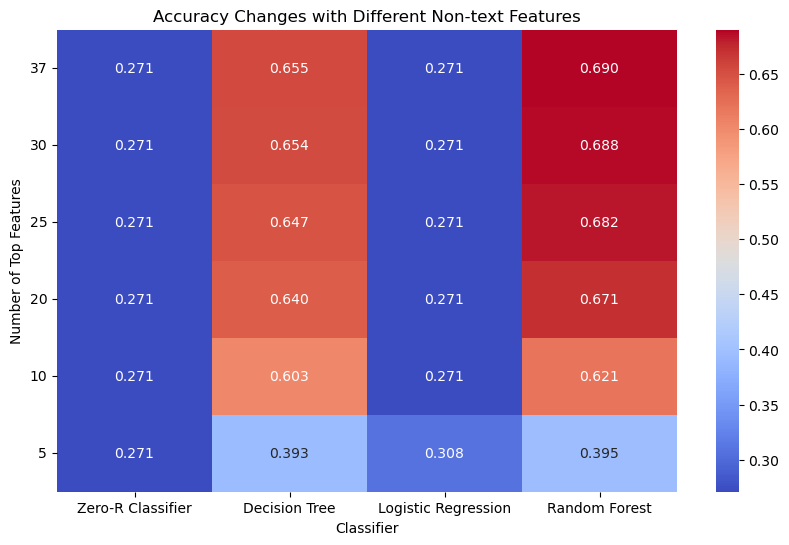

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Dictionary to store accuracies for each model
accuracies = {name: [] for name in classifiers}

for k in k_values:
    #print(f"\nTop {k} Features:")
    
    # Initialize SelectKBest with ANOVA F-value as the scoring function
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_label_non_text_selected = selector.fit_transform(X_train_label_non_text, y_train_label)
    X_evaluate_label_non_text_selected = selector.transform(X_evaluate_label_non_text)
    
    # Get the indices of the selected features
    selected_feature_indices = selector.get_support()
    
    # Get the names of the selected features
    selected_feature_names = X_train_label_non_text.columns[selected_feature_indices]
    #print("Selected Features:", selected_feature_names)
    
    # Evaluate classifiers using the selected features
    for name, classifier in classifiers.items():
        # Train classifier on selected features
        classifier.fit(X_train_label_non_text_selected, y_train_label)
        
        # Predict
        y_pred = classifier.predict(X_evaluate_label_non_text_selected)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_evaluate_label, y_pred)
        accuracies[name].append(accuracy)

# Convert accuracies dictionary to DataFrame for heatmap
accuracies_df = pd.DataFrame(accuracies, index=k_values)

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(accuracies_df, annot=True, cmap="coolwarm", fmt=".3f")
plt.title('Accuracy Changes with Different Non-text Features')
plt.xlabel('Classifier')
plt.ylabel('Number of Top Features')
plt.yticks(rotation=0)
plt.show()

### Draw confusion matrix to compare the accuracy with or without balanced datasets

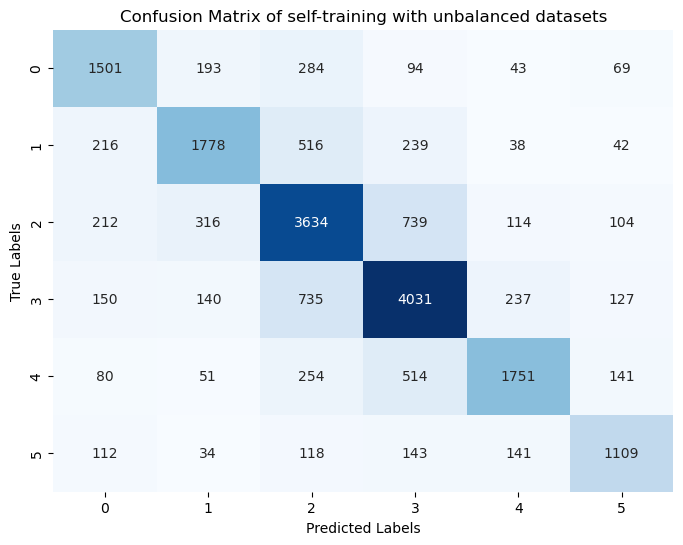

In [93]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_evaluate_label, y_pred_eval)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of self-training with unbalanced datasets')
plt.show()

In [94]:
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_label), y=y_train_label)

# train rf using balanced data
balanced_rf_model = RandomForestClassifier(criterion='entropy', class_weight=dict(zip(np.unique(y_train_label), class_weights)))

#-----

X_train_both = np.vstack([X_train_label_non_text, X_unlabel_non_text])
print(X_train_both.shape)

# Create labels for unlabeled data (use -1 to represent unlabeled data)
y_both = y_train_label.to_list() + [-1] * (X_unlabel_non_text.shape[0])


# Train a semi-supervised learning model

self_training_model = SelfTrainingClassifier(balanced_rf_model, criterion = 'k_best', k_best=1000)
self_training_model.fit(X_train_both, y_both)

y_pred_eval = self_training_model.predict(X_evaluate_label_non_text)

(354701, 37)


C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


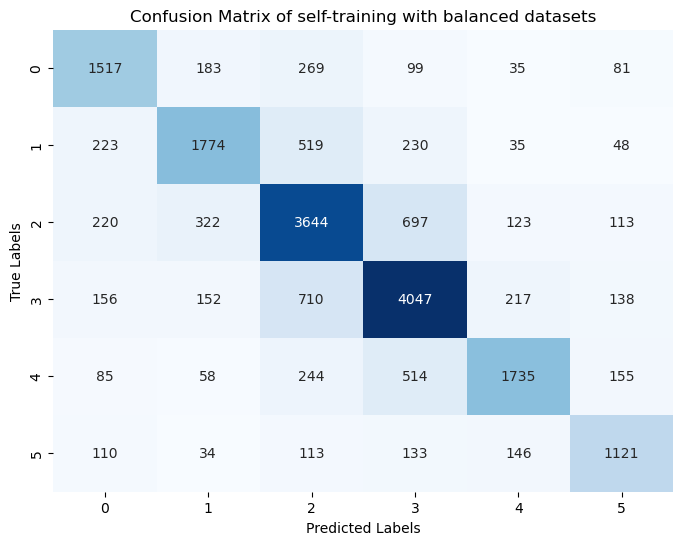

In [96]:
# Compute confusion matrix
cm = confusion_matrix(y_evaluate_label, y_pred_eval)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of self-training with balanced datasets')
plt.show()

### Learning curve to check overfitting and underfitting

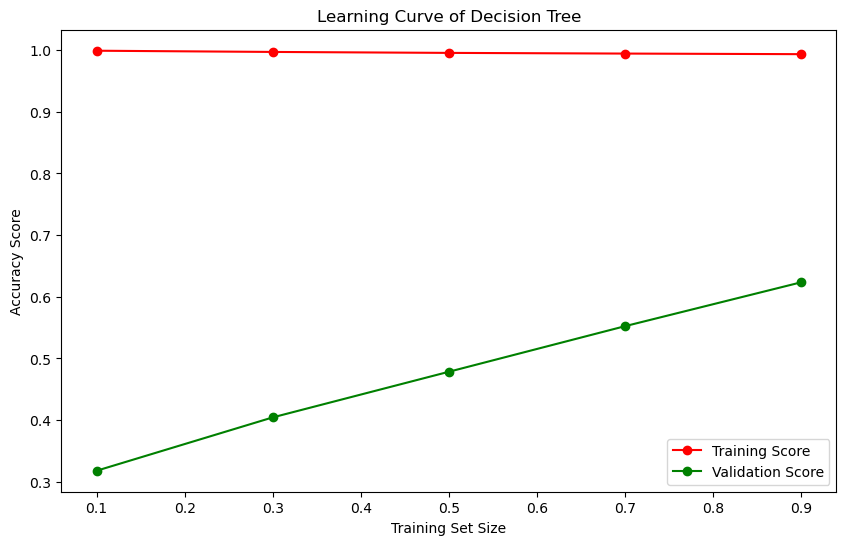

In [51]:
decision_tree_classifier = DecisionTreeClassifier(criterion='entropy')

train_scores = []
val_scores = []
train_sizes = np.array([0.1, 0.3, 0.5, 0.7, 0.9])

for train_size in train_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train_label_non_text, y_train_label, train_size=train_size, random_state=42)
    decision_tree_classifier.fit(X_train_subset, y_train_subset)
    y_train_pred = decision_tree_classifier.predict(X_train_subset)
    y_val_pred = decision_tree_classifier.predict(X_evaluate_label_non_text)
    train_scores.append(accuracy_score(y_train_subset, y_train_pred))
    val_scores.append(accuracy_score(y_evaluate_label, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, val_scores, 'o-', color='g', label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve of Decision Tree')
plt.legend(loc='best')
plt.show()

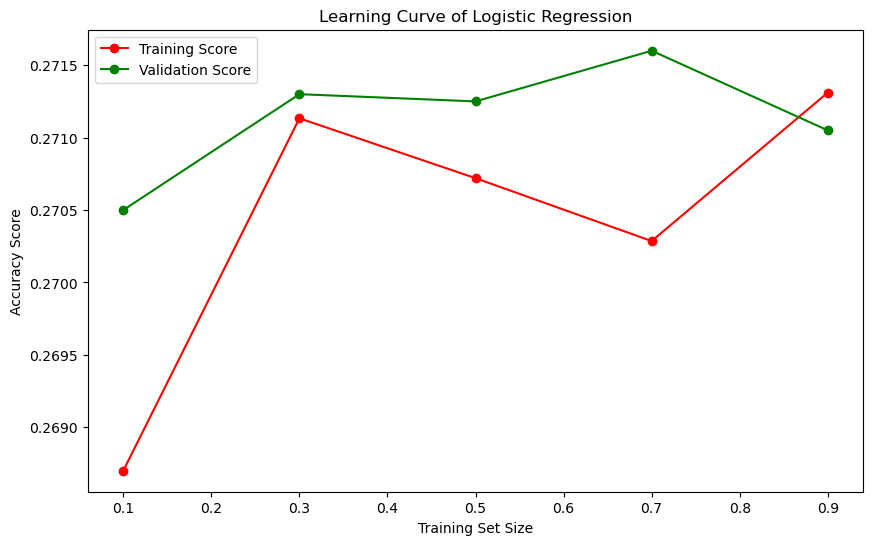

In [52]:
lgr = LogisticRegression(max_iter=1000)

train_scores = []
val_scores = []
train_sizes = np.array([0.1, 0.3, 0.5, 0.7, 0.9])

for train_size in train_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train_label_non_text, y_train_label, train_size=train_size, random_state=42)
    lgr.fit(X_train_subset, y_train_subset)
    y_train_pred = lgr.predict(X_train_subset)
    y_val_pred = lgr.predict(X_evaluate_label_non_text)
    train_scores.append(accuracy_score(y_train_subset, y_train_pred))
    val_scores.append(accuracy_score(y_evaluate_label, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, val_scores, 'o-', color='g', label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve of Logistic Regression')
plt.legend(loc='best')
plt.show()

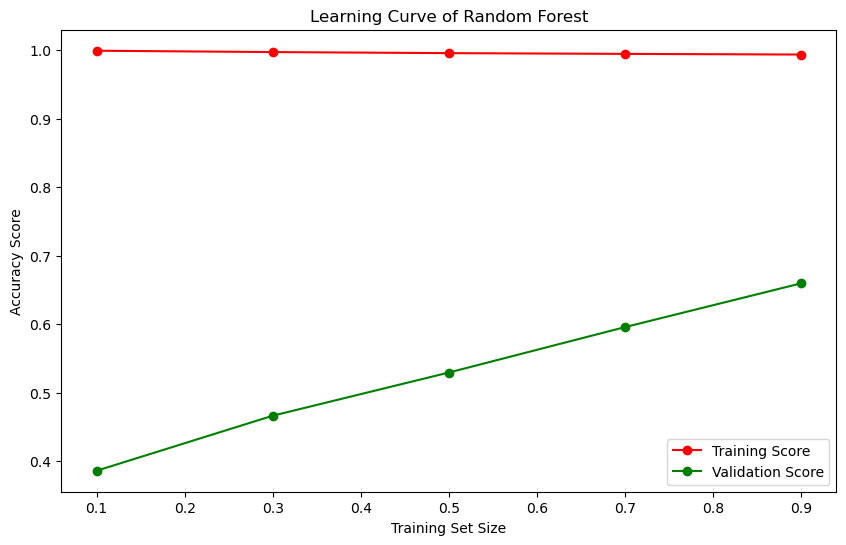

In [53]:
rf_classifier = RandomForestClassifier(criterion='entropy')

train_scores = []
val_scores = []
train_sizes = np.array([0.1, 0.3, 0.5, 0.7, 0.9])

for train_size in train_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train_label_non_text, y_train_label, train_size=train_size, random_state=42)
    rf_classifier.fit(X_train_subset, y_train_subset)
    y_train_pred = rf_classifier.predict(X_train_subset)
    y_val_pred = rf_classifier.predict(X_evaluate_label_non_text)
    train_scores.append(accuracy_score(y_train_subset, y_train_pred))
    val_scores.append(accuracy_score(y_evaluate_label, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, val_scores, 'o-', color='g', label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve of Random Forest')
plt.legend(loc='best')
plt.show()

C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\semi_supervised\_self_training.py:214: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\semi_supervised\_self_training.py:219: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\semi_supervised\_self_training.py:214: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\semi_supervised\_self_training.py:219: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  warnings.warn(
C:\Users\Yuting\anaconda3\Lib\site-packages\sklearn\semi_supervised\_self_training.py:214: UserWarning: y contains no unlabele

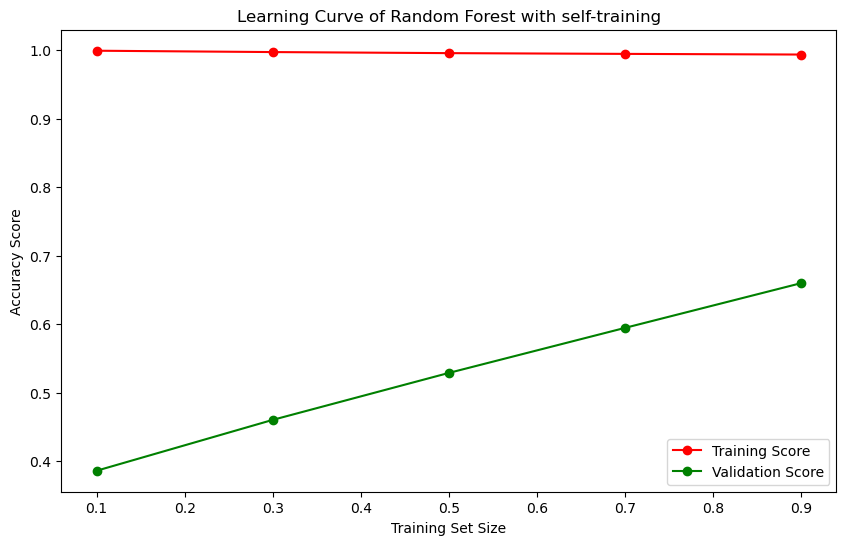

In [98]:
# Train a semi-supervised learning model

self_training_model = SelfTrainingClassifier(rf_classifier, criterion = 'k_best', k_best=1000)
self_training_model.fit(X_train_both, y_both)

train_scores = []
val_scores = []
train_sizes = np.array([0.1, 0.3, 0.5, 0.7, 0.9])

for train_size in train_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train_label_non_text, y_train_label, train_size=train_size, random_state=42)
    self_training_model.fit(X_train_subset, y_train_subset)
    y_train_pred = self_training_model.predict(X_train_subset)
    y_val_pred = self_training_model.predict(X_evaluate_label_non_text)
    train_scores.append(accuracy_score(y_train_subset, y_train_pred))
    val_scores.append(accuracy_score(y_evaluate_label, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, val_scores, 'o-', color='g', label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve of Random Forest with self-training')
plt.legend(loc='best')
plt.show()

### Draw a bar chart comparison of model precision with and without Self-Training (non-text)

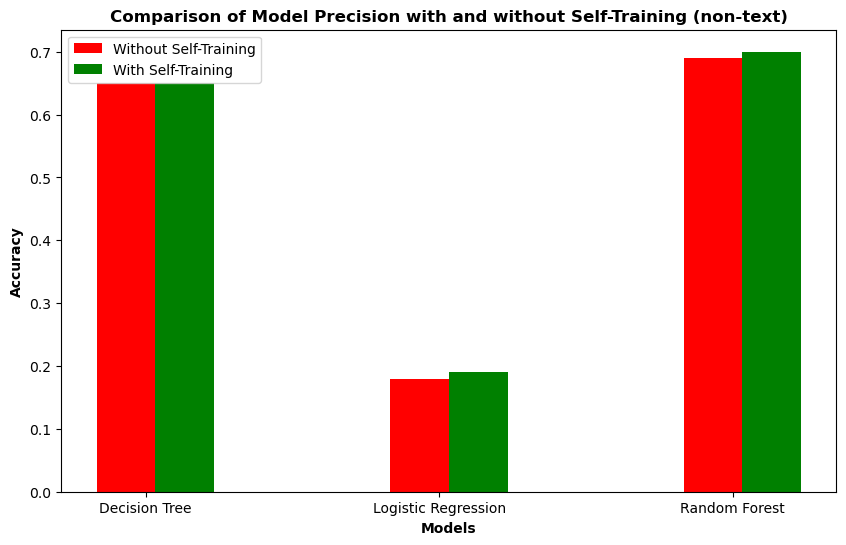

In [68]:
# Define the model names
model_names = ['Decision Tree', 'Logistic Regression', 'Random Forest']

# Define the accuracies without self-training
accuracies_without_self_training = [0.65, 0.18, 0.69]

# Define the accuracies with self-training
accuracies_with_self_training = [0.65, 0.19, 0.70]

# Set the width of the bars
bar_width = 0.2

# Set the position of the bars on the x-axis
r1 = range(len(model_names))
r2 = [x + bar_width for x in r1]

# Plotting the bars
plt.figure(figsize=(10, 6))
plt.bar(r1, accuracies_without_self_training, color='red', width=bar_width, label='Without Self-Training')
plt.bar(r2, accuracies_with_self_training, color='green', width=bar_width, label='With Self-Training')

# Adding labels
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + bar_width/3 for r in r1], model_names)
plt.title('Comparison of Model Precision with and without Self-Training (non-text)', fontweight='bold')
plt.legend()

# Show plot
plt.show()